# Helper Functions and Training Procedure:

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mnist import MNIST
from skimage.feature import hog
import itertools

In [13]:
from sklearn import svm

In [17]:
from sklearn import neighbors

In [3]:
def generate_hog(X, cell_size=(8,8)):
    hog_img=[]
    for img in X:
        vec=hog(img, pixels_per_cell=cell_size)
        hog_img.append(vec)
    return np.asarray(hog_img)

In [4]:
def Sigmoid(x):
    return np.asarray(1/(1+np.exp(-x)))

def ReLU(x):
    return np.asarray(np.maximum(0,x))

def Softmax(x):
    b=np.exp(x)
    c=np.sum(b, axis=0)
    d=np.divide(b, c)
    return d

def ReLU_grad(x):
    return np.heaviside(x,0)

def Sigmoid_grad(x):
    return np.asarray(np.multiply(Sigmoid(x),1-Sigmoid(x)))

def CrossEntropy(target_, output_):
    return np.sum(-np.sum(np.multiply(target_, np.log((output_))), axis=0))

def CrossEntropy_grad(target_, output_):
    return -np.divide(target_, output_)

def Softmax_CE_grad(target_, pred_):
    grad=-pred_+target_
    return grad

In [5]:
def add_noise(images):
    size=images.shape
    x=np.random.normal(loc=0.0, scale=10, size=size)
    noisy=np.add(images,x)
    return noisy

def labels_to_class(labels):
    return np.argmax(labels, axis=1)

def confusion_matrix(target_, pred):
    size=len(target_[0])
    target_class=labels_to_class(target_)
    pred_class=labels_to_class(pred)
    cm=np.zeros([size, size])
    for a,p in zip(target_class, pred_class):
        cm[a][p]+=1
    return cm

def cm_metrics(cm):
    diag=(np.diagonal(cm))
    psum=np.sum(cm, axis=0, dtype=np.float32)
    rsum=np.sum(cm, axis=1, dtype=np.float32)
    p=np.divide(diag, psum)
    r=np.divide(diag, rsum)
    prod=np.multiply(p,r)
    sum_=p+r
    f=2*np.divide(prod,sum_)
    a=1.*np.sum(diag)/np.sum(cm)
    return (a,p,r,f)
    
def plot_confusion_matrix(cm, target_names, title='Confusion matrix',):

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_loss(train_loss, test_loss, title):
    x=200*np.arange(0, len(train_loss))
    plt.plot(x,train_loss, label='Train')
    plt.plot(x,test_loss, label='Test')
    plt.title(title)
    plt.xlabel("Iterations")
    plt.ylabel("Average Loss")
    plt.legend(loc='upper left')
    plt.show()
    
def top_k_pred(pred, k):
    sort=np.argsort(pred, axis=0)
    return sort[::-1][:k]

In [6]:
def shuffle_data(images, labels):
    index=np.random.permutation(len(images))
    shuff_images, shuff_labels=images[index], labels[index]
    return shuff_images, shuff_labels

def get_split_mask(images):
    size=len(images)/5
    a=np.ones(5*size, dtype=bool)
    b=np.arange(10)
    mask=[]
    for i in range(5):
        mask.append([False if (j<(i+1)*size)&(j>=(i)*size) else x for j,x in enumerate(a)])
    return mask

def get_split_data(mask, images, labels, index):
    mask_=mask[index]
    train_images=images[mask_]
    train_labels=labels[mask_]
    inv_mask_=np.invert(mask_)
    test_images=images[inv_mask_]
    test_labels=labels[inv_mask_]
    return train_images, train_labels, test_images, test_labels

def get_accuracy(model, test_images, test_labels):
    batch_size=len(test_images[0])
    count=np.zeros(batch_size)
    pred=model.forward(test_images)
    count=[1 if np.argmax(pred[:,i], axis=0)==np.argmax(test_labels[:,i], axis=0) else 0 for i in range(batch_size)]
    correct=np.sum(count)
    accuracy=100*correct/batch_size
    return(pred, accuracy)

def SGD_mom(model, batch_images, batch_labels, l2):
    batch_size=len(batch_images[0])
    loss=model.update(batch_images, batch_labels, l2)
    return loss
    
def one_hot(labels):
    a=np.zeros((len(labels), 10))
    a[np.arange(len(labels)),labels]=1
    return a

In [7]:
class MLP(object):
    def __init__(self, input_size, h1_size, h2_size, output_size):
        self.W1=np.random.normal(loc=0.0, scale=0.08, size=(h1_size, input_size) )
        self.W2=np.random.normal(loc=0.0, scale=0.08, size=(h2_size, h1_size) )
        self.W3=np.random.normal(loc=0.0, scale=0.08, size=(output_size, h2_size) )
        self.B1=np.zeros(h1_size).reshape(-1,1)
        self.B2=np.zeros(h2_size).reshape(-1,1)
        self.B3=np.zeros(output_size).reshape(-1,1)
        
        self.W1_grad=np.zeros_like(self.W1)
        self.W2_grad=np.zeros_like(self.W2)
        self.W3_grad=np.zeros_like(self.W3)
        self.B1_grad=np.zeros_like(self.B1)
        self.B2_grad=np.zeros_like(self.B2)
        self.B3_grad=np.zeros_like(self.B3)
        
        self.W1_mom=np.zeros_like(self.W1)
        self.W2_mom=np.zeros_like(self.W2)
        self.W3_mom=np.zeros_like(self.W3)
        self.B1_mom=np.zeros_like(self.B1)
        self.B2_mom=np.zeros_like(self.B2)
        self.B3_mom=np.zeros_like(self.B3)
        
        
    def update(self, input_, target_, l2=0):

        batch_size=len(input_[0])
        x=input_
        h1=np.add(np.matmul(self.W1, input_), self.B1)
        a1=act[act_ind](h1)
        h2=np.add(np.matmul(self.W2, a1), self.B2)
        a2=act[act_ind](h2)
        h3=np.add(np.matmul(self.W3, a2), self.B3)
        a3=Softmax(h3)
        
        loss=CrossEntropy(target_, a3)
        _E_h3=Softmax_CE_grad(a3, target_)
        
        _a2_h2=act_grad[act_ind](h2)
        _a1_h1=act_grad[act_ind](h1)
        
        _E_W3=np.matmul(_E_h3,np.transpose(a2))
        _E_B3=np.sum(_E_h3, axis=1).reshape(-1,1)
        _E_a2=np.matmul(np.transpose(self.W3), _E_h3)
        
        _E_h2=np.multiply(_E_a2, _a2_h2)
        _E_W2=np.matmul(_E_h2, np.transpose(a1))
        _E_B2=np.sum(_E_h2, axis=1).reshape(-1,1)
        _E_a1=np.matmul(np.transpose(self.W2), _E_h2)
        
        _E_h1=np.multiply(_E_a1, _a1_h1)
        _E_W1=np.matmul(_E_h1, np.transpose(x))
        _E_B1=np.sum(_E_h1, axis=1).reshape(-1,1)
        _E_x=np.matmul(np.transpose(self.W1), _E_h1)
        
        self.W1_grad=_E_W1/batch_size+self.W1*2*l2
        self.W2_grad=_E_W2/batch_size+self.W2*2*l2
        self.W3_grad=_E_W3/batch_size+self.W3*2*l2
        self.B1_grad=_E_B1/batch_size
        self.B2_grad=_E_B2/batch_size
        self.B3_grad=_E_B3/batch_size
                
        self.W1_mom=gamma*self.W1_mom+lr*self.W1_grad
        self.W2_mom=gamma*self.W2_mom+lr*self.W2_grad
        self.W3_mom=gamma*self.W3_mom+lr*self.W3_grad
        self.B1_mom=gamma*self.B1_mom+lr*self.B1_grad
        self.B2_mom=gamma*self.B2_mom+lr*self.B2_grad
        self.B3_mom=gamma*self.B3_mom+lr*self.B3_grad
        
        self.W1-=self.W1_mom
        self.W2-=self.W2_mom
        self.W3-=self.W3_mom
        self.B1=self.B1-self.B1_mom
        self.B2=self.B2-self.B2_mom
        self.B3=self.B3-self.B3_mom

        return loss
    
    def forward(self, input_):
        x=input_
        h1=np.add(np.matmul(self.W1, input_), self.B1)
        a1=act[act_ind](h1)
        h2=np.add(np.matmul(self.W2, a1), self.B2)
        a2=act[act_ind](h2)
        h3=np.add(np.matmul(self.W3, a2), self.B3)
        a3=Softmax(h3)
        return a3

In [28]:
input_size=81
h1_size=500
h2_size=250
output_size=10
gamma=0.99
lr=1e-3
act_ind=0
batch_size=64
epochs=10
act=[Sigmoid, ReLU]
act_grad=[Sigmoid_grad, ReLU_grad]
actstr={0:'Sigmoid',1:'ReLU'}

In [9]:
from mnist import MNIST
data=MNIST('/home/pradeep/data/')
images, labels_ = data.load_training()

images=np.asarray(images)
labels_=np.asarray(labels_)
images=images.reshape(-1,28,28)

act=[Sigmoid, ReLU]
act_grad=[Sigmoid_grad, ReLU_grad]

images, labels_=shuffle_data(images, labels_)
labels=one_hot(labels_)
mask=get_split_mask(images)
hog_img=generate_hog(X=images)
hog_img*=255

/home/pradeep/.local/lib/python2.7/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


In [27]:
def train(model, epochs, images, labels, fold_index, l2=0):
    train_loss=[]
    test_loss=[]
    train_images, train_labels, test_images, test_labels=get_split_data(mask, images, labels, fold_index)
    num_batches=len(train_images)/batch_size
    batch_images=np.array_split(train_images, num_batches)
    batch_labels=np.array_split(train_labels, num_batches)
    for epoch in range(epochs):
        for i in range(num_batches):
            size=len(batch_images[i])
            loss=SGD_mom(model, np.transpose(batch_images[i]), np.transpose(batch_labels[i]), l2=l2)
            train_avg_loss=loss/size
            if((i)%200==0):
                print("Epoch "+str(epoch+1)+" Iteration "+str(i+1)+" : Avg Loss = "+str(train_avg_loss))
                pred, accuracy=get_accuracy(model, np.transpose(test_images), np.transpose(test_labels))
                test_avg_loss= CrossEntropy(np.transpose(test_labels), pred)/len(test_images)
                train_loss.append(train_avg_loss)
                test_loss.append(test_avg_loss)
    plot_loss(train_loss, test_loss, "Plot of loss for "+actstr[act_ind]+" for Fold "+str(fold_index+1))
    output_cm_scores(model, test_images, test_labels)
    #plot_images(model, test_images[:20], 3)

In [10]:
def output_cm_scores_(pred, labels):
    cm=confusion_matrix_(pred=pred, target_=labels)
    a,p,r,f=cm_metrics(cm)
    print "Accuracy = "+ str(a)
    print "Precision = ", p
    print "Recall = ", r
    print "F1 Score = ", f
    target_names=['0','1','2','3','4','5','6','7','8','9']
    plot_confusion_matrix(cm,target_names)
    
def confusion_matrix_(target_, pred):
    size=10
    cm=np.zeros([size, size])
    for a,p in zip(target_, pred):
        cm[a][p]+=1
    return cm    

In [18]:
def train_KNN(hog_img, labels, fold_index):
    KNN=neighbors.KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    mask=get_split_mask(hog_img)
    train_hog, train_labels, test_hog, test_labels=get_split_data(images=hog_img, labels=labels_, mask=mask, index=fold_index)
    KNN.fit(train_hog, train_labels)
    pred=KNN.predict(test_hog)
    output_cm_scores_(pred, np.transpose(test_labels))

In [1]:
def train_SVM(hog_img, labels, fold_index):
    SVM=svm.LinearSVC(random_state=0)
    mask=get_split_mask(hog_img)
    train_hog, train_labels, test_hog, test_labels=get_split_data(images=hog_img, labels=labels_, mask=mask, index=fold_index)
    SVM.fit(train_hog, train_labels)
    pred=SVM.predict(test_hog)
    output_cm_scores_(pred,np.transpose(test_labels))

# Training Results:


### Sigmoid Activation: Fold - 1 , Learning Rate=1e-3

Epoch 1 Iteration 1 : Avg Loss = 2.5237310604414125
Epoch 1 Iteration 201 : Avg Loss = 0.884445213530523
Epoch 1 Iteration 401 : Avg Loss = 0.35903156786276985
Epoch 1 Iteration 601 : Avg Loss = 0.3655924703778429
Epoch 2 Iteration 1 : Avg Loss = 0.10902911774288424
Epoch 2 Iteration 201 : Avg Loss = 0.36398440514331526
Epoch 2 Iteration 401 : Avg Loss = 0.2258086851886312
Epoch 2 Iteration 601 : Avg Loss = 0.22260797401805532
Epoch 3 Iteration 1 : Avg Loss = 0.05129968587343006
Epoch 3 Iteration 201 : Avg Loss = 0.26492773978105
Epoch 3 Iteration 401 : Avg Loss = 0.1559271781710433
Epoch 3 Iteration 601 : Avg Loss = 0.1737974770920139
Epoch 4 Iteration 1 : Avg Loss = 0.03843904655200772
Epoch 4 Iteration 201 : Avg Loss = 0.22684122539521784
Epoch 4 Iteration 401 : Avg Loss = 0.11652301922279068
Epoch 4 Iteration 601 : Avg Loss = 0.14757747366434396
Epoch 5 Iteration 1 : Avg Loss = 0.031926515058978984
Epoch 5 Iteration 201 : Avg Loss = 0.20134238224677115
Epoch 5 Iteration 401 : Avg L

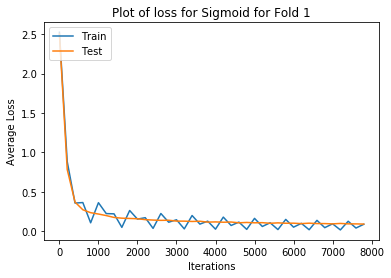

Accuracy = 0.96625
Precision =  [0.98682043 0.98937785 0.95641447 0.94204019 0.98188406 0.97920605
 0.96700508 0.96642097 0.9691358  0.92851469]
Recall =  [0.98763397 0.98415094 0.97485331 0.97833066 0.94838145 0.95308188
 0.99046794 0.94551282 0.92508418 0.97173732]
F1 Score =  [0.98722703 0.98675747 0.96554587 0.95984252 0.96484201 0.96596737
 0.97859589 0.95585257 0.94659776 0.94963444]


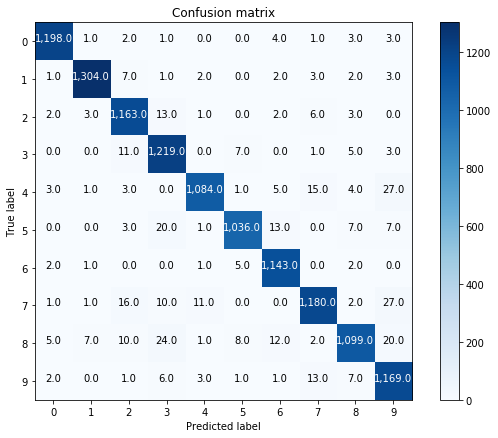

In [71]:
model0=MLP(input_size, h1_size, h2_size, output_size)
train(images=hog_img, labels=labels, epochs=10, fold_index=0, model=model0)

### Sigmoid Activation: Fold - 2 , Learning Rate=1e-3

Epoch 1 Iteration 1 : Avg Loss = 2.3486130349224137
Epoch 1 Iteration 201 : Avg Loss = 0.8805077968073363
Epoch 1 Iteration 401 : Avg Loss = 0.35118200690820534
Epoch 1 Iteration 601 : Avg Loss = 0.3774719906840963
Epoch 2 Iteration 1 : Avg Loss = 0.15647418099205188
Epoch 2 Iteration 201 : Avg Loss = 0.33701204427867015
Epoch 2 Iteration 401 : Avg Loss = 0.2292529184510146
Epoch 2 Iteration 601 : Avg Loss = 0.2673917212471495
Epoch 3 Iteration 1 : Avg Loss = 0.10403024286388032
Epoch 3 Iteration 201 : Avg Loss = 0.2429156371271068
Epoch 3 Iteration 401 : Avg Loss = 0.17408084793344306
Epoch 3 Iteration 601 : Avg Loss = 0.2241918291408031
Epoch 4 Iteration 1 : Avg Loss = 0.08549408312668665
Epoch 4 Iteration 201 : Avg Loss = 0.1959961144193908
Epoch 4 Iteration 401 : Avg Loss = 0.14028176742571927
Epoch 4 Iteration 601 : Avg Loss = 0.1952009737202599
Epoch 5 Iteration 1 : Avg Loss = 0.07061118638707099
Epoch 5 Iteration 201 : Avg Loss = 0.1664451775125741
Epoch 5 Iteration 401 : Avg Lo

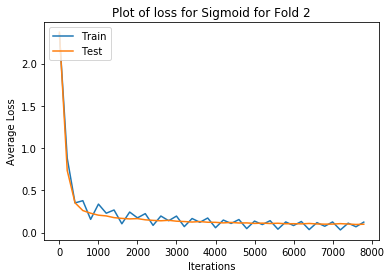

Accuracy = 0.9668333333333333
Precision =  [0.98489933 0.98317484 0.96714406 0.93044822 0.98196573 0.9820949
 0.96473552 0.97442244 0.97563177 0.92804579]
Recall =  [0.98160535 0.98606016 0.96632997 0.97806661 0.93960311 0.9580786
 0.98966408 0.95938262 0.93512111 0.97008547]
F1 Score =  [0.98324958 0.98461538 0.96673684 0.95366337 0.96031746 0.96993811
 0.97704082 0.96684404 0.954947   0.94860008]


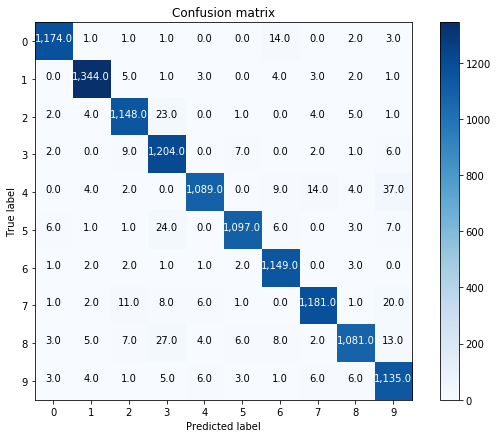

In [73]:
model1=MLP(input_size, h1_size, h2_size, output_size)
train(images=hog_img, labels=labels, epochs=10, fold_index=1, model=model1)

### Sigmoid Activation: Fold - 3 , Learning Rate=1e-3

Epoch 1 Iteration 1 : Avg Loss = 2.5608770701074492
Epoch 1 Iteration 201 : Avg Loss = 0.7373994279409963
Epoch 1 Iteration 401 : Avg Loss = 0.3313299908022806
Epoch 1 Iteration 601 : Avg Loss = 0.36246301735684483
Epoch 2 Iteration 1 : Avg Loss = 0.15393990487147974
Epoch 2 Iteration 201 : Avg Loss = 0.19700579478168634
Epoch 2 Iteration 401 : Avg Loss = 0.23658798412097798
Epoch 2 Iteration 601 : Avg Loss = 0.2266668083979541
Epoch 3 Iteration 1 : Avg Loss = 0.10315344828157831
Epoch 3 Iteration 201 : Avg Loss = 0.16379690605442782
Epoch 3 Iteration 401 : Avg Loss = 0.1771364006606284
Epoch 3 Iteration 601 : Avg Loss = 0.16940896725257232
Epoch 4 Iteration 1 : Avg Loss = 0.08072841023500066
Epoch 4 Iteration 201 : Avg Loss = 0.14181660492921588
Epoch 4 Iteration 401 : Avg Loss = 0.14119408430178249
Epoch 4 Iteration 601 : Avg Loss = 0.1442354279861858
Epoch 5 Iteration 1 : Avg Loss = 0.0663022074929781
Epoch 5 Iteration 201 : Avg Loss = 0.12267082325345313
Epoch 5 Iteration 401 : Avg

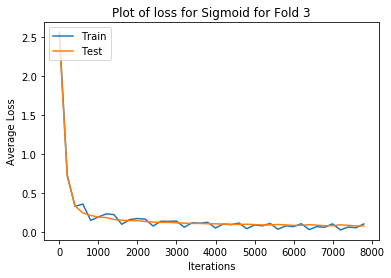

Accuracy = 0.9691666666666666
Precision =  [0.99087894 0.98875562 0.96545914 0.94784026 0.98577778 0.97619048
 0.96523848 0.98146656 0.97610619 0.91686461]
Recall =  [0.9859736  0.98359433 0.97614991 0.97240803 0.94624573 0.9743346
 0.995      0.95379796 0.92301255 0.98052498]
F1 Score =  [0.98842018 0.98616822 0.9707751  0.95996698 0.96560731 0.97526166
 0.97989331 0.96743447 0.9488172  0.94762684]


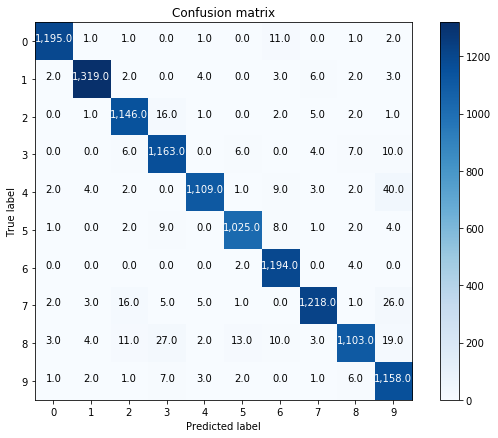

In [74]:
model2=MLP(input_size, h1_size, h2_size, output_size)
train(images=hog_img, labels=labels, epochs=10, fold_index=2, model=model2)

### Sigmoid Activation: Fold - 4 , Learning Rate=1e-3

Epoch 1 Iteration 1 : Avg Loss = 2.61727318186808
Epoch 1 Iteration 201 : Avg Loss = 0.8704242156675674
Epoch 1 Iteration 401 : Avg Loss = 0.3838612418083182
Epoch 1 Iteration 601 : Avg Loss = 0.34807333461493795
Epoch 2 Iteration 1 : Avg Loss = 0.1340971846288544
Epoch 2 Iteration 201 : Avg Loss = 0.21459745950758458
Epoch 2 Iteration 401 : Avg Loss = 0.2222683176918635
Epoch 2 Iteration 601 : Avg Loss = 0.2132056718473819
Epoch 3 Iteration 1 : Avg Loss = 0.08956229127077667
Epoch 3 Iteration 201 : Avg Loss = 0.17164518048850474
Epoch 3 Iteration 401 : Avg Loss = 0.16195204657385218
Epoch 3 Iteration 601 : Avg Loss = 0.1658042036857238
Epoch 4 Iteration 1 : Avg Loss = 0.07350707623568369
Epoch 4 Iteration 201 : Avg Loss = 0.1488588781812995
Epoch 4 Iteration 401 : Avg Loss = 0.13192430967350516
Epoch 4 Iteration 601 : Avg Loss = 0.14221631945540786
Epoch 5 Iteration 1 : Avg Loss = 0.06533641702178208
Epoch 5 Iteration 201 : Avg Loss = 0.12490333848970356
Epoch 5 Iteration 401 : Avg Lo

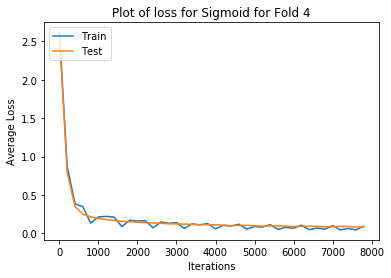

Accuracy = 0.9705
Precision =  [0.97584124 0.98529412 0.95929769 0.9625498  0.99021352 0.98167792
 0.97233523 0.96024942 0.97971781 0.94246353]
Recall =  [0.98950131 0.98301158 0.9796251  0.97734628 0.93529412 0.96128423
 0.99087894 0.96779262 0.94312394 0.97485331]
F1 Score =  [0.98262381 0.98415153 0.96935484 0.96989161 0.96197061 0.97137405
 0.98151951 0.96400626 0.96107266 0.95838484]


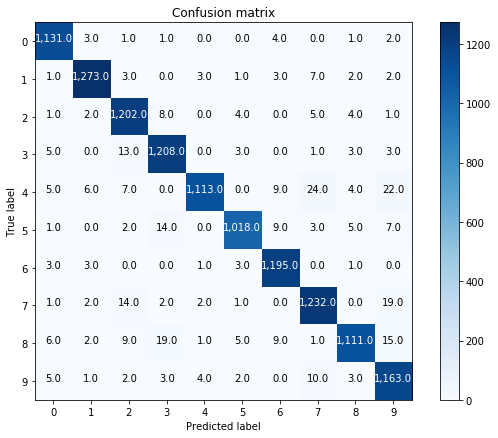

In [75]:
model3=MLP(input_size, h1_size, h2_size, output_size)
train(images=hog_img, labels=labels, epochs=10, fold_index=3, model=model3)

### ReLU Activation: Fold - 1 , Learning Rate=5e-4

Epoch 1 Iteration 1 : Avg Loss = 9.120454114316132
Epoch 1 Iteration 201 : Avg Loss = 0.3695540096432324
Epoch 1 Iteration 401 : Avg Loss = 0.2563435714996035
Epoch 1 Iteration 601 : Avg Loss = 0.2329868392901371
Epoch 2 Iteration 1 : Avg Loss = 0.033891931897472014
Epoch 2 Iteration 201 : Avg Loss = 0.32103634967947414
Epoch 2 Iteration 401 : Avg Loss = 0.16219619921774103
Epoch 2 Iteration 601 : Avg Loss = 0.13502726609932056
Epoch 3 Iteration 1 : Avg Loss = 0.01103076294020759
Epoch 3 Iteration 201 : Avg Loss = 0.2586787284343916
Epoch 3 Iteration 401 : Avg Loss = 0.1622301980850681
Epoch 3 Iteration 601 : Avg Loss = 0.0983698625045581
Epoch 4 Iteration 1 : Avg Loss = 0.008943218464390768
Epoch 4 Iteration 201 : Avg Loss = 0.2421379000804832
Epoch 4 Iteration 401 : Avg Loss = 0.16164700315441405
Epoch 4 Iteration 601 : Avg Loss = 0.15484803320905666
Epoch 5 Iteration 1 : Avg Loss = 0.009118390863813414
Epoch 5 Iteration 201 : Avg Loss = 0.21582579941580404
Epoch 5 Iteration 401 : Av

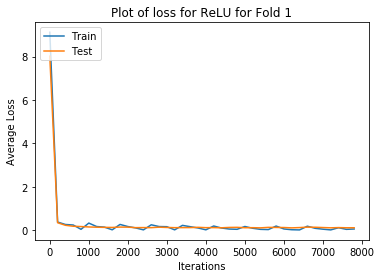

Accuracy = 0.96825
Precision =  [0.98676592 0.98429319 0.95358306 0.95070423 0.96542783 0.98745174
 0.96537162 0.96593674 0.95768566 0.96694915]
Recall =  [0.98351195 0.99320755 0.98155909 0.97512039 0.97725284 0.94112236
 0.99046794 0.95432692 0.93350168 0.94846218]
F1 Score =  [0.98513625 0.98873028 0.96736886 0.96275753 0.97130435 0.96373057
 0.97775877 0.96009674 0.94543905 0.95761645]


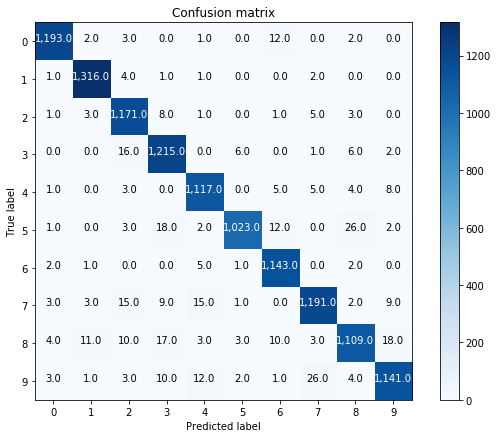

In [78]:
model0=MLP(input_size, h1_size, h2_size, output_size)
train(images=hog_img, labels=labels, epochs=10, fold_index=0, model=model0)

### ReLU Activation: Fold - 2 , Learning Rate=5e-4

Epoch 1 Iteration 1 : Avg Loss = 5.686153496418004
Epoch 1 Iteration 201 : Avg Loss = 0.4629774230970316
Epoch 1 Iteration 401 : Avg Loss = 0.17903476425572615
Epoch 1 Iteration 601 : Avg Loss = 0.21012480867141517
Epoch 2 Iteration 1 : Avg Loss = 0.05348664507058814
Epoch 2 Iteration 201 : Avg Loss = 0.22230705885393404
Epoch 2 Iteration 401 : Avg Loss = 0.1792182683996405
Epoch 2 Iteration 601 : Avg Loss = 0.11641789411432661
Epoch 3 Iteration 1 : Avg Loss = 0.07433463501481997
Epoch 3 Iteration 201 : Avg Loss = 0.16261710529705697
Epoch 3 Iteration 401 : Avg Loss = 0.12071240316830212
Epoch 3 Iteration 601 : Avg Loss = 0.13939150151652466
Epoch 4 Iteration 1 : Avg Loss = 0.052717498876482194
Epoch 4 Iteration 201 : Avg Loss = 0.13673239208360083
Epoch 4 Iteration 401 : Avg Loss = 0.07667629642699361
Epoch 4 Iteration 601 : Avg Loss = 0.08814960443377175
Epoch 5 Iteration 1 : Avg Loss = 0.02887043707787417
Epoch 5 Iteration 201 : Avg Loss = 0.09594533241439655
Epoch 5 Iteration 401 :

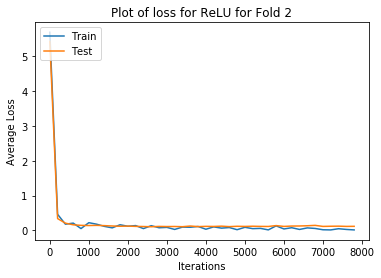

Accuracy = 0.9673333333333334
Precision =  [0.98826488 0.98243045 0.97140454 0.95987159 0.97942755 0.98454545
 0.97198642 0.9814346  0.95682211 0.90134175]
Recall =  [0.98578595 0.98459281 0.97222222 0.97156783 0.94477998 0.94585153
 0.98621878 0.94476036 0.95847751 0.97606838]
F1 Score =  [0.98702386 0.98351044 0.97181321 0.9656843  0.96179183 0.96481069
 0.97905088 0.96274834 0.95764909 0.93721789]


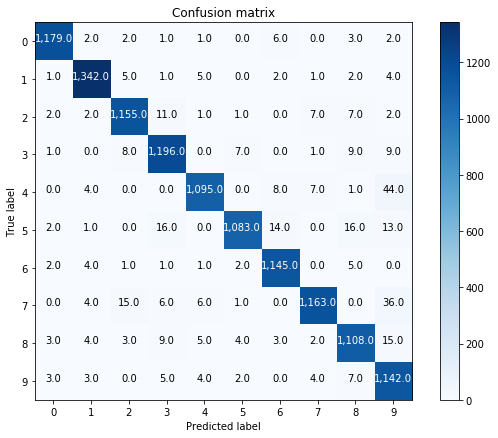

In [79]:
model1=MLP(input_size, h1_size, h2_size, output_size)
train(images=hog_img, labels=labels, epochs=10, fold_index=1, model=model1)

### ReLU Activation: Fold - 3 , Learning Rate=5e-4

Epoch 1 Iteration 1 : Avg Loss = 7.7289568417855055
Epoch 1 Iteration 201 : Avg Loss = 0.4767908575414811
Epoch 1 Iteration 401 : Avg Loss = 0.3539230563369344
Epoch 1 Iteration 601 : Avg Loss = 0.19498260146854265
Epoch 2 Iteration 1 : Avg Loss = 0.11988889014426031
Epoch 2 Iteration 201 : Avg Loss = 0.15201172364305393
Epoch 2 Iteration 401 : Avg Loss = 0.1918882570027483
Epoch 2 Iteration 601 : Avg Loss = 0.1381031830695138
Epoch 3 Iteration 1 : Avg Loss = 0.10103946291874161
Epoch 3 Iteration 201 : Avg Loss = 0.10967983019753948
Epoch 3 Iteration 401 : Avg Loss = 0.09412550603307032
Epoch 3 Iteration 601 : Avg Loss = 0.08914121278336554
Epoch 4 Iteration 1 : Avg Loss = 0.07045661571137758
Epoch 4 Iteration 201 : Avg Loss = 0.07562473876215411
Epoch 4 Iteration 401 : Avg Loss = 0.0635467723364539
Epoch 4 Iteration 601 : Avg Loss = 0.07559270580111976
Epoch 5 Iteration 1 : Avg Loss = 0.04826412348498155
Epoch 5 Iteration 201 : Avg Loss = 0.05572940869537378
Epoch 5 Iteration 401 : Av

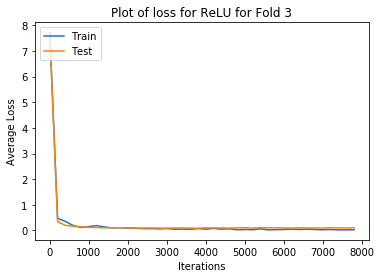

Accuracy = 0.9659166666666666
Precision =  [0.98763397 0.98805078 0.96711636 0.94809408 0.98405669 0.98336595
 0.95458167 0.97502082 0.97465035 0.9029734 ]
Recall =  [0.98844884 0.98657718 0.9770017  0.97742475 0.94795222 0.95532319
 0.99833333 0.91699295 0.93305439 0.97713802]
F1 Score =  [0.98804124 0.98731343 0.9720339  0.96253602 0.9656671  0.96914176
 0.97596741 0.94511703 0.95339889 0.93859292]


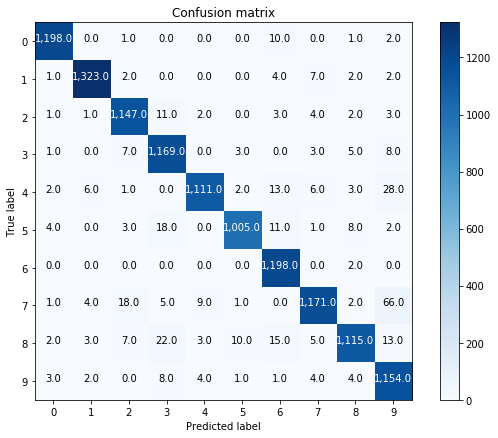

In [80]:
model2=MLP(input_size, h1_size, h2_size, output_size)
train(images=hog_img, labels=labels, epochs=10, fold_index=2, model=model2)

### ReLU Activation: Fold - 4 , Learning Rate=5e-4

Epoch 1 Iteration 1 : Avg Loss = 8.73148664539806
Epoch 1 Iteration 201 : Avg Loss = 0.3428013177751035
Epoch 1 Iteration 401 : Avg Loss = 0.23369188384478579
Epoch 1 Iteration 601 : Avg Loss = 0.2042677366311289
Epoch 2 Iteration 1 : Avg Loss = 0.17110737835237658
Epoch 2 Iteration 201 : Avg Loss = 0.20369544499754108
Epoch 2 Iteration 401 : Avg Loss = 0.17257317536873873
Epoch 2 Iteration 601 : Avg Loss = 0.13164172663356488
Epoch 3 Iteration 1 : Avg Loss = 0.08116140438953583
Epoch 3 Iteration 201 : Avg Loss = 0.15247239997726222
Epoch 3 Iteration 401 : Avg Loss = 0.10891679864831445
Epoch 3 Iteration 601 : Avg Loss = 0.0962537658825236
Epoch 4 Iteration 1 : Avg Loss = 0.0628560789125494
Epoch 4 Iteration 201 : Avg Loss = 0.13475861205303025
Epoch 4 Iteration 401 : Avg Loss = 0.08095876305624854
Epoch 4 Iteration 601 : Avg Loss = 0.06913590105589297
Epoch 5 Iteration 1 : Avg Loss = 0.06665181353210972
Epoch 5 Iteration 201 : Avg Loss = 0.0662147601957997
Epoch 5 Iteration 401 : Avg 

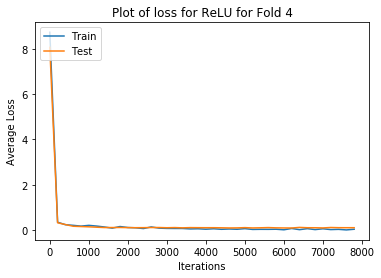

Accuracy = 0.9680833333333333
Precision =  [0.98688811 0.98684211 0.95863166 0.95800317 0.99539595 0.9892051
 0.97547016 0.96075353 0.94920899 0.92834138]
Recall =  [0.98775153 0.98455598 0.98207009 0.97815534 0.90840336 0.95184136
 0.98922056 0.96150825 0.96774194 0.96647108]
F1 Score =  [0.98731963 0.98569772 0.97020934 0.96797438 0.94991213 0.97016362
 0.98229724 0.96113074 0.95838588 0.94702259]


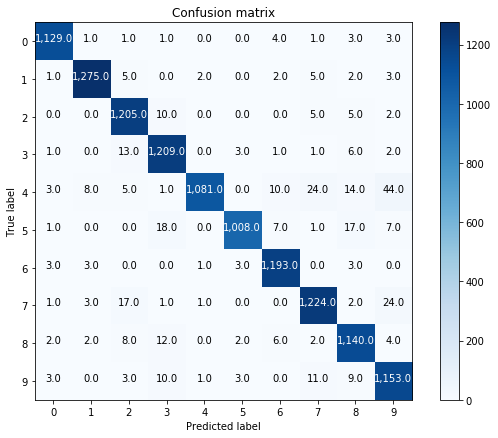

In [81]:
model3=MLP(input_size, h1_size, h2_size, output_size)
train(images=hog_img, labels=labels, epochs=10, fold_index=3, model=model3)

### ReLU Activation: Fold - 5 , Learning Rate=5e-4

Epoch 1 Iteration 1 : Avg Loss = 6.452419998397894
Epoch 1 Iteration 201 : Avg Loss = 0.40023061029722135
Epoch 1 Iteration 401 : Avg Loss = 0.17510700787350808
Epoch 1 Iteration 601 : Avg Loss = 0.11678254612431363
Epoch 2 Iteration 1 : Avg Loss = 0.07297036524886916
Epoch 2 Iteration 201 : Avg Loss = 0.1881079525044066
Epoch 2 Iteration 401 : Avg Loss = 0.1888615387786949
Epoch 2 Iteration 601 : Avg Loss = 0.14828309971065878
Epoch 3 Iteration 1 : Avg Loss = 0.0691296822765721
Epoch 3 Iteration 201 : Avg Loss = 0.10173555418989014
Epoch 3 Iteration 401 : Avg Loss = 0.14566269985428876
Epoch 3 Iteration 601 : Avg Loss = 0.11688379121844969
Epoch 4 Iteration 1 : Avg Loss = 0.04856110558598667
Epoch 4 Iteration 201 : Avg Loss = 0.07830608669722441
Epoch 4 Iteration 401 : Avg Loss = 0.07990529918493103
Epoch 4 Iteration 601 : Avg Loss = 0.09795277032129626
Epoch 5 Iteration 1 : Avg Loss = 0.028402865971453164
Epoch 5 Iteration 201 : Avg Loss = 0.08302671915807842
Epoch 5 Iteration 401 : 

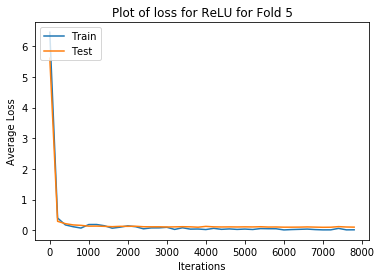

Accuracy = 0.97075
Precision =  [0.98040886 0.98308668 0.9734589  0.94976077 0.97108844 0.95687332
 0.99146758 0.96209677 0.96024735 0.97743056]
Recall =  [0.9930975  0.98377997 0.96683673 0.97463175 0.96943973 0.98794063
 0.97076023 0.96521036 0.95855379 0.93677205]
F1 Score =  [0.98671239 0.9834332  0.97013652 0.96203554 0.97026338 0.97215883
 0.98100464 0.96365105 0.95939982 0.9566695 ]


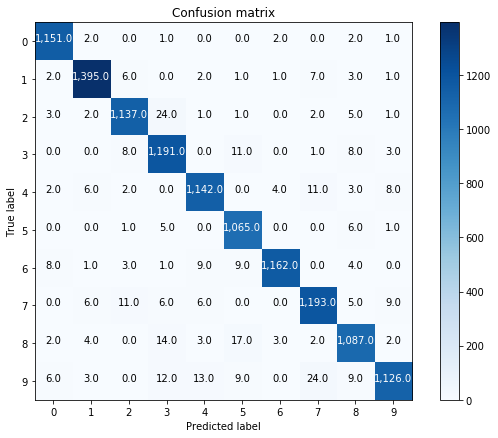

In [82]:
model4=MLP(input_size, h1_size, h2_size, output_size)
train(images=hog_img, labels=labels, epochs=10, fold_index=4, model=model4)

### KNN: Fold-1

Accuracy = 0.9524166666666667
Precision =  [0.95335968 0.99086062 0.97929249 0.93665875 0.95259799 0.9804878
 0.96872358 0.95496247 0.91451613 0.89888535]
Recall =  [0.99422918 0.98188679 0.95138307 0.9494382  0.91426072 0.92456302
 0.99306759 0.91746795 0.95454545 0.93848712]
F1 Score =  [0.97336562 0.9863533  0.96513605 0.94300518 0.93303571 0.95170455
 0.98074454 0.9358398  0.93410214 0.91825946]


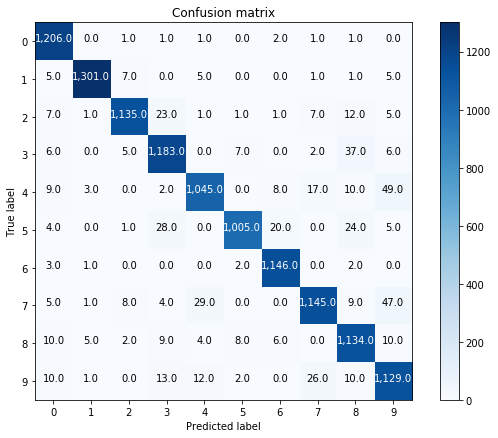

In [117]:
train_KNN(hog_img, labels, fold_index=0)

### KNN: Fold-2

Accuracy = 0.96475
Precision =  [0.97532895 0.98965262 0.98289136 0.94732642 0.98001817 0.98903108
 0.97292724 0.97145256 0.93366501 0.90850202]
Recall =  [0.9916388  0.98239178 0.96717172 0.9642567  0.93097498 0.94497817
 0.99052541 0.93988627 0.97404844 0.95897436]
F1 Score =  [0.98341625 0.98600884 0.97496818 0.95571659 0.95486726 0.9665029
 0.98164746 0.95540875 0.9534293  0.93305613]


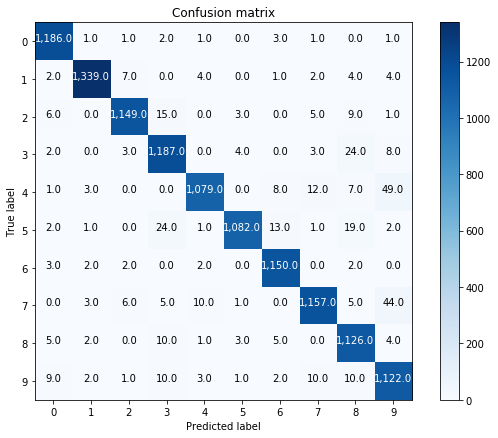

In [120]:
train_KNN(hog_img, labels, fold_index=1)

### KNN: Fold-3

Accuracy = 0.9575833333333333
Precision =  [0.95833333 0.98688047 0.97846684 0.94741167 0.96930946 0.98510427
 0.9672696  0.9734589  0.93021412 0.88880368]
Recall =  [0.99207746 0.97973951 0.95542473 0.94975288 0.92892157 0.9271028
 0.99468556 0.92288961 0.96622735 0.95785124]
F1 Score =  [0.97491349 0.98329702 0.96680851 0.94858083 0.94868586 0.95522388
 0.98078603 0.9475     0.94787879 0.9220366 ]


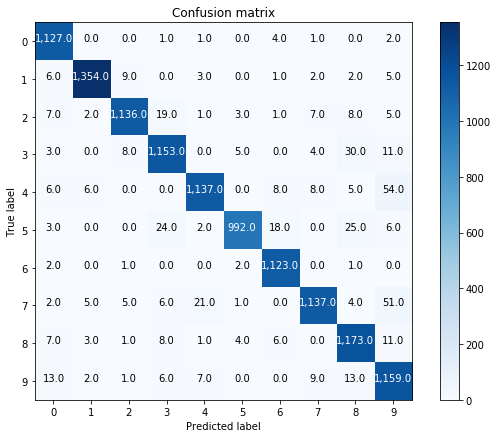

In [19]:
train_KNN(hog_img, labels, fold_index=2)

### KNN: Fold-4

Accuracy = 0.95475
Precision =  [0.9699187  0.98171178 0.98198971 0.92598684 0.96744186 0.9782197
 0.96405751 0.97729184 0.92460646 0.88003221]
Recall =  [0.99333888 0.9874908  0.94706369 0.94781145 0.91148116 0.93146979
 0.98934426 0.92222222 0.9530316  0.95709282]
F1 Score =  [0.9814891  0.98459281 0.96421053 0.93677205 0.93862816 0.95427252
 0.97653722 0.94895876 0.93860387 0.91694631]


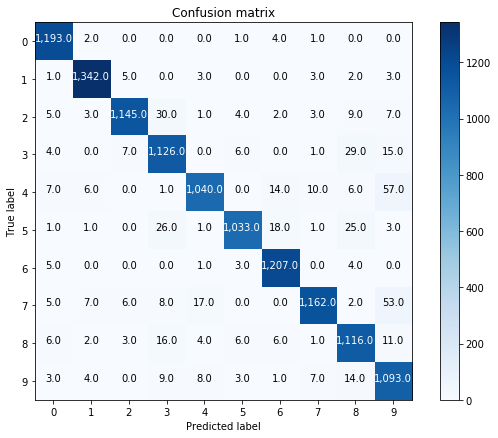

In [21]:
train_KNN(hog_img, labels, fold_index=3)

### KNN: Fold-5

Accuracy = 0.9555833333333333
Precision =  [0.9645799  0.98604651 0.97719595 0.92211838 0.96332737 0.97965116
 0.9693301  0.96522477 0.9343696  0.90168971]
Recall =  [0.99237288 0.98223938 0.95540875 0.94947875 0.93246753 0.95557656
 0.98766447 0.91405622 0.94250871 0.94297189]
F1 Score =  [0.97827903 0.98413926 0.96617954 0.93559858 0.94764628 0.96746411
 0.97841141 0.93894389 0.93842151 0.92186887]


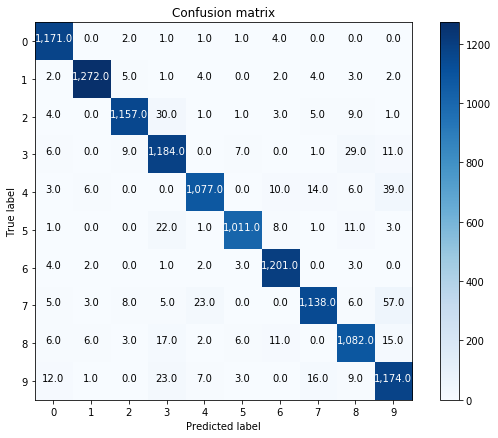

In [23]:
train_KNN(hog_img, labels, fold_index=4)

### SVM: Fold-1

Accuracy = 0.9051666666666667
Precision =  [0.95993459 0.96594203 0.79044118 0.98103267 0.86525974 0.89948007
 0.96822742 0.90025795 0.83442623 0.91006233]
Recall =  [0.97427386 0.96454414 0.942156   0.75020145 0.94086496 0.94794521
 0.93236715 0.85260586 0.8783434  0.87052811]
F1 Score =  [0.96705107 0.96524258 0.85965614 0.85022831 0.90147992 0.92307692
 0.94995898 0.87578419 0.85582177 0.88985633]


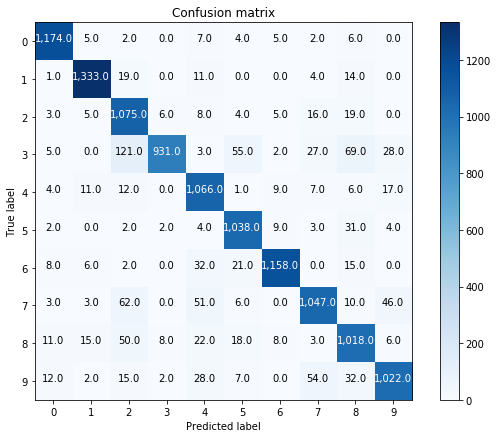

In [14]:
train_SVM(hog_img, labels, 0)

### SVM: Fold-2

Accuracy = 0.904
Precision =  [0.98327465 0.97709321 0.82517986 0.91619203 0.9456838  0.95292988
 0.82361734 0.88880064 0.88776449 0.87326247]
Recall =  [0.93005828 0.93429003 0.94950331 0.9073328  0.82001682 0.91092746
 0.99189919 0.86076923 0.83261432 0.90662139]
F1 Score =  [0.9559264  0.95521236 0.88298691 0.91174089 0.87837838 0.9314554
 0.89995917 0.87456038 0.85930543 0.88962932]


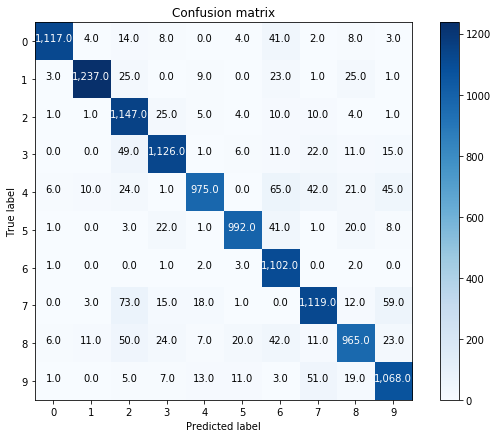

In [15]:
train_SVM(hog_img, labels, 1)

### SVM: Fold-3

Accuracy = 0.9221666666666667
Precision =  [0.95614789 0.93508287 0.9004894  0.90969345 0.89671737 0.92377495
 0.95446585 0.91723549 0.88569145 0.94903846]
Recall =  [0.97887324 0.97973951 0.92851135 0.90444811 0.91503268 0.95140187
 0.96545616 0.87256494 0.91268534 0.81570248]
F1 Score =  [0.96737712 0.95689046 0.91428571 0.9070632  0.90578245 0.9373849
 0.95992955 0.89434276 0.8989858  0.87733333]


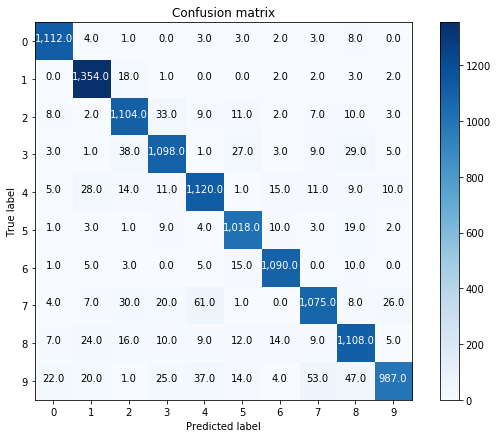

In [20]:
train_SVM(hog_img, labels, 2)

### SVM: Fold-4

Accuracy = 0.8910833333333333
Precision =  [0.99328215 0.9886823  0.84627093 0.92554194 0.90747331 0.85575365
 0.94271686 0.94048693 0.70297657 0.89053803]
Recall =  [0.86178185 0.89992642 0.9197684  0.82659933 0.89395267 0.9522092
 0.9442623  0.82777778 0.94790777 0.84063047]
F1 Score =  [0.92287115 0.9422188  0.88149029 0.87327701 0.90066225 0.90140845
 0.94348894 0.88054031 0.80727273 0.86486486]


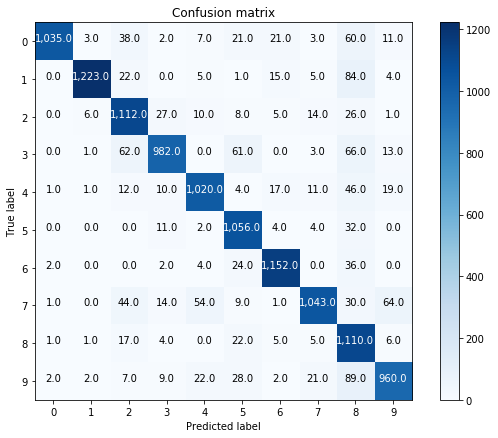

In [22]:
train_SVM(hog_img, labels, 3)

### SVM: Fold-5

Accuracy = 0.8936666666666667
Precision =  [0.95684647 0.95249042 0.91852487 0.87348485 0.83665644 0.87381158
 0.97885463 0.97280593 0.85244444 0.77679783]
Recall =  [0.97711864 0.95984556 0.88439306 0.92461909 0.94458874 0.95557656
 0.91365132 0.63212851 0.83536585 0.91967871]
F1 Score =  [0.96687631 0.95615385 0.90113589 0.89832489 0.88735258 0.91286682
 0.94512973 0.76630964 0.84381874 0.8422214 ]


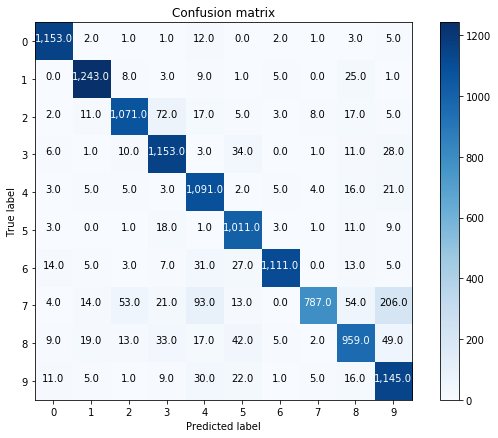

In [24]:
train_SVM(hog_img, labels, 4)